In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from collections import defaultdict
from IPython.display import display
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import load_data
from constants import DATA_DIR, EVENTS_DIR, DEM_SUBREDDITS, REP_SUBREDDITS, PARTISAN_SUBREDDITS

In [18]:
dev = False

In [19]:
reddit = load_data(DATA_DIR, year=2016, tokenize=False, comp="parquet", dev=False)

Loading data of 2016...


In [20]:
if dev:
    reduction_frac = 0.15
    print(f'Reduce data to fraction {reduction_frac}')

    reddit = reddit.sample(frac=reduction_frac)

In [21]:
users = defaultdict(list)

for index, row in reddit[["author", "subreddit"]].iterrows():
    if row['subreddit'] in PARTISAN_SUBREDDITS:
        users[row['author']].append(row['subreddit'])

In [22]:
users_n_posts_df = pd.DataFrame([[user, len(users[user])] for user in users.keys()],
                                columns = ['user', 'n_posts'])
users_n_posts_df.to_csv(f'{DATA_DIR}/users_n_posts.csv')

In [23]:
# from nltk.tokenize import word_tokenize
# from nltk.stem import LancasterStemmer

# st = LancasterStemmer()

BREXIT = 'brexit'
# BREX_LEMMAS = set([st.stem(word) for word in ['vote', 'leave', 'remain', 'referendum', 'cameron', 'uk', 'british']])
BREXIT_DATE = pd.to_datetime('2016-06-23')
START_RANGE = BREXIT_DATE - pd.Timedelta(90, unit='d')
END_RANGE = BREXIT_DATE + pd.Timedelta(90, unit='d')


In [24]:
def calculate_partisan_score(subreddits_list):
    score = 0
    for subreddit in subreddits_list:
        if subreddit in DEM_SUBREDDITS:
            score += 1
        elif subreddit in REP_SUBREDDITS:
            score -= 1
    return score


def is_rep_or_dem(score):
    if score >= 1:
        return 'D'
    elif score <= -1:
        return 'R'
    return 'N'


def includes_lemma(post):
    # tokens = word_tokenize(post)
    # tokenized_post = set([st.stem(token.lower()) for token in tokens])
    # if np.sum([lemm in BREX_LEMMAS for lemm in tokenized_post]) >= 2:
    #     return True
    return BREXIT in post.lower()


def is_around_event_date(date):
    timestamp = pd.to_datetime(date)
    return timestamp.between(START_RANGE, END_RANGE)

In [25]:
user_affiliation = {}
users_affiliation_data = []

for key in users.keys():
    partisan_score = calculate_partisan_score(users[key])
    if abs(partisan_score) > 5:
        users_affiliation_data.append([key, partisan_score, is_rep_or_dem(partisan_score)])
        user_affiliation[key] = is_rep_or_dem(partisan_score)

users_affiliation_df = pd.DataFrame(users_affiliation_data, columns=['user', 'score', 'leaning'])

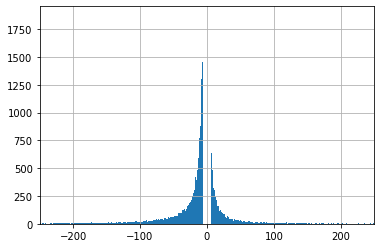

In [26]:
users_affiliation_df['score'].hist(bins=np.linspace(-250, 250, 500))
# plt.semilogx()
plt.xlim(-250,250)
plt.show()

In [27]:
users_affiliation_df.to_csv(f'{EVENTS_DIR}/brexit_user_affiliation.csv')

with open(f"{DATA_DIR}/user_affiliation.json", "w") as outfile:
    json.dump(user_affiliation, outfile)

### Checkpoint

In [28]:
try:
    user_affiliation
except NameError:
    print("Load user affiliation dict")
    f = open(f"{DATA_DIR}/user_affiliation.json")
    user_affiliation = json.load(f)

In [30]:
data = []

# [reddit.subreddit = "politics"]
reddit = reddit[["author", "body", "created_utc", "subreddit"]].compute()

if dev:
    reddit = reddit.iloc[np.random.randint(0,
                                           len(reddit),
                                           size=int(0.15 * len(reddit)))]

author_ = reddit.author.values
created_ = reddit.created_utc.values
body_ = reddit.body.values
subreddit_ = reddit.subreddit.values

for author, created, body, subreddit in zip(author_, created_, body_, subreddit_):
    if author in user_affiliation and is_around_event_date(created_) and includes_lemma(body):
        affiliation = user_affiliation[author]
        data.append([author, body, created, affiliation, subreddit])

output_dataframe = pd.DataFrame(
    data, columns=['author', 'post', 'time', 'politics', 'subreddit'])

In [1]:
output_dataframe.to_csv(f'{EVENTS_DIR}/brexit.csv')

In [ ]:
display(output_dataframe)

In [ ]:
output_dataframe['politics'].hist()
plt.show()